In [2]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
import numpy as np
import keras
from keras.applications.imagenet_utils import decode_predictions
import skimage.io 
import skimage.segmentation
import copy
import sklearn
import sklearn.metrics
from sklearn.linear_model import LinearRegression
import warnings
from keras.models import load_model
def perturb_image(img,perturbation,segments):
    active_pixels = np.where(perturbation == 1)[0]
    mask = np.zeros(segments.shape)
    for active in active_pixels:
        mask[segments == active] = 1 
    perturbed_image = copy.deepcopy(img)
    perturbed_image = perturbed_image*mask[:,:,np.newaxis]
    return perturbed_image
def changeImageSize(maxWidth, maxHeight, image):
    widthRatio  = maxWidth/image.size[0]
    heightRatio = maxHeight/image.size[1]
    newWidth    = int(widthRatio*image.size[0])
    newHeight   = int(heightRatio*image.size[1])
    newImage    = image.resize((newWidth, newHeight))
    return newImage
def nparrtoimage(array):
    array_n = np.reshape(array, (64, 64,3))
    data = Image.fromarray((array_n * 255).astype(np.uint8))
    return data
def ExplainableAI(image,pre_trained_model):
  IMAGE_SIZE = 64
  image= cv2.resize(np.array(image.copy()), (IMAGE_SIZE, IMAGE_SIZE), interpolation=cv2.INTER_AREA)
  image=image/255.0
  normal_image = image
  model = pre_trained_model
  preds = model.predict(image[np.newaxis,:,:,:])
  superpixels = skimage.segmentation.quickshift(image, kernel_size=2,max_dist=200, ratio=0.2)
  num_superpixels = np.unique(superpixels).shape[0]
  num_perturb = 200
  perturbations = np.random.binomial(1, 0.5, size=(num_perturb, num_superpixels))
  predictions = []
  for pert in perturbations:
    perturbed_img = perturb_image(image,pert,superpixels)
    pred = model.predict(perturbed_img[np.newaxis,:,:,:])
    predictions.append(pred)
  predictions = np.array(predictions)
  original_image = np.ones(num_superpixels)[np.newaxis,:] #Perturbation with all superpixels enabled 
  distances = sklearn.metrics.pairwise_distances(perturbations,original_image, metric='cosine').ravel()
  kernel_width = 0.25
  weights = np.sqrt(np.exp(-(distances**2)/kernel_width**2)) #Kernel function
  class_to_explain = 0# has higher probability  
  if preds[0][1]>preds[0][0]:
    class_to_explain=1
  simpler_model = LinearRegression()
  simpler_model.fit(X=perturbations, y=predictions[:,:,class_to_explain], sample_weight=weights)
  coeff = simpler_model.coef_[0]
  num_top_features = 3
  top_features = np.argsort(coeff)[-num_top_features:] 
  mask = np.zeros(num_superpixels) 
  mask[top_features]= True #Activate top superpixels
  skimage.io.imshow(perturb_image(image,mask,superpixels) )
  data = nparrtoimage(perturb_image(image,mask,superpixels))
  #plt.imshow(data)
  data.save('1.png')
  data = cv2.imread('1.png')
  #colormap = plt.get_cmap('inferno')
  heatmap = cv2.applyColorMap(data, cv2.COLORMAP_HOT)
  heatmap_image = nparrtoimage(heatmap)
  plt.imshow(heatmap_image)
  image1 = nparrtoimage(normal_image)
  image2 = heatmap_image
  image1 = changeImageSize(64, 64, image1)
  image2 = changeImageSize(64, 64, image2)
  alphaBlended = Image.blend(image1, image2, alpha=.6)
  return alphaBlended

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
os.chdir('/content/drive/MyDrive/final_year_project_dataset')
model = load_model("model.h5")

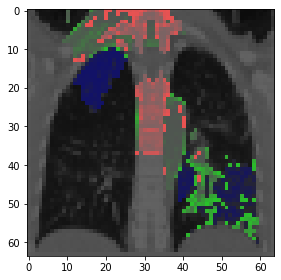

In [ ]:
trial = cv2.imread('Trial.png')
ans2 = ExplainableAI(trial,model)
plt.imshow(ans2)

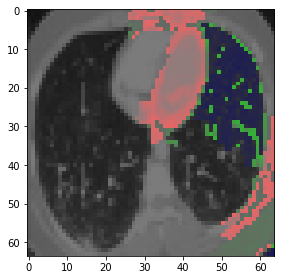

In [ ]:
trial = cv2.imread('try.png')
ans2 = ExplainableAI(trial,model)
plt.imshow(ans2)

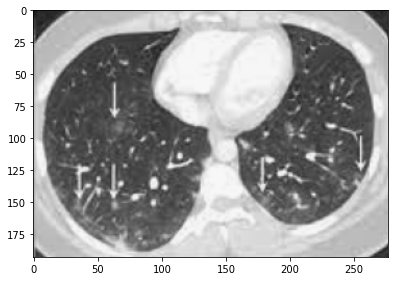

In [ ]:
trial = cv2.imread('try.png')
ans2 = two(trial,model)
plt.imshow(trial)

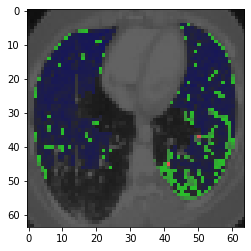

In [ ]:
plt.imshow(ans2)